In [31]:
from Class import SchwarzschildPerturbation, gaussian_initial_profile
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, fftshift, ifft, ifftshift, fftfreq
import numpy.polynomial.polynomial as poly

In [32]:
j = complex(0, 1)

#Parameters
M = 1
l = 2
parity = 'axial'

rstar_min = -800
rstar_max = 800
dx = 0.08

#Initialise Simulation
axial_sim = SchwarzschildPerturbation(M, l, parity, rstar_min, rstar_max, dx = 0.08, dt = 0.4*dx)

#Initial data
width = 10*M
rstar0 = 200*M
omega = 0.7
# Psi0 = np.random.randn(len(axial_sim.rstar))
# dPsi0 = np.random.randn(len(axial_sim.rstar))
Psi0 = 1/(np.sqrt(2*np.pi*width**2))*np.exp(-(axial_sim.rstar - rstar0)**2/(2*width**2))*np.exp(-j*omega*axial_sim.rstar)
dPsi0 = (-j*omega - (axial_sim.rstar - rstar0)/width**2)*Psi0

sim = axial_sim.solve(Psi0, 20000, dPsi0)
# sim.make_gif()


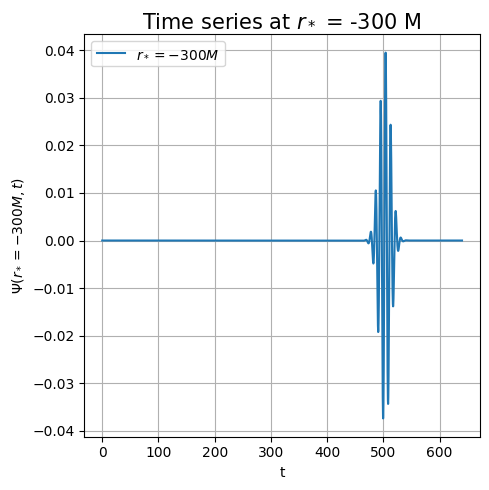

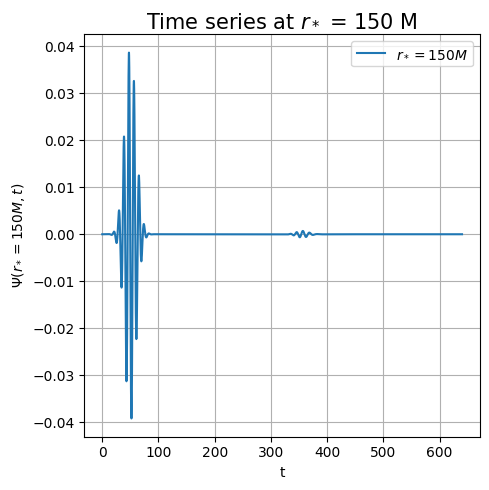

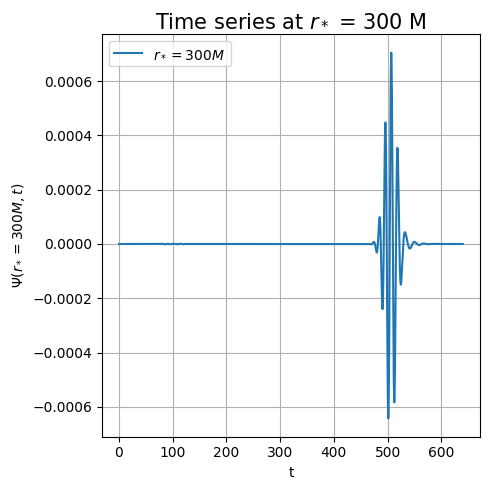

(3, 20000)


In [33]:
Psi = sim.Psi
times = sim.times

extraction_radii = [-300, 150, 300]

time_series = []
for x in extraction_radii:
    idx = np.argmin(np.abs(axial_sim.rstar - x*axial_sim.M))
    extraction = Psi[:, idx]
    time_series.append(extraction)
    plt.figure(figsize = (5, 5))
    plt.plot(times, extraction.real, label = rf'$r_* = {x} M$')
    plt.xlabel('t', fontsize = 10)
    plt.ylabel(rf'$\Psi (r_*={x} M, t)$', fontsize = 10)
    plt.title(rf'Time series at $r_*$ = {x} M', fontsize = 15)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

time_series = np.array(time_series)
print(time_series.shape)

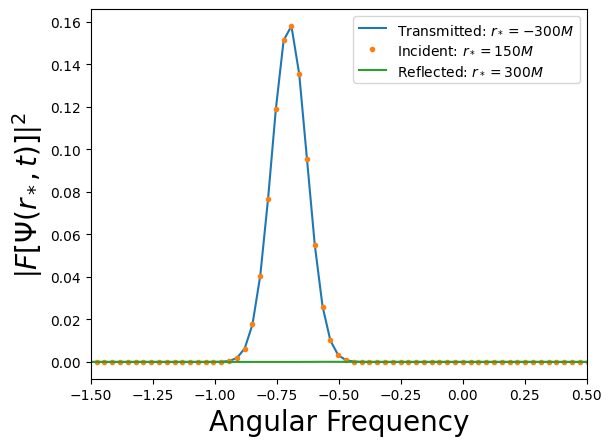

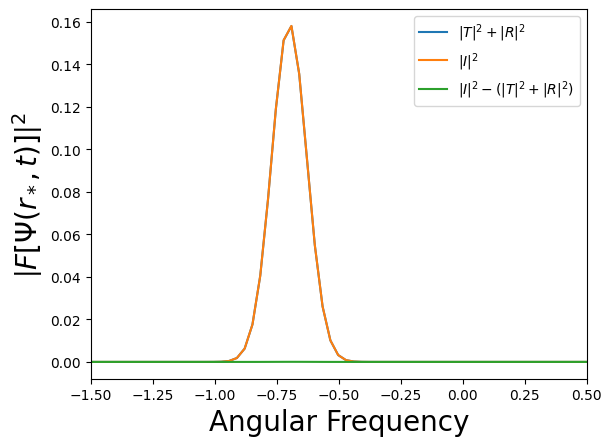

[3.97457067e-19 3.27091388e-18 3.96530239e-19 ... 3.26915217e-18
 3.99132697e-19 3.26986448e-18]


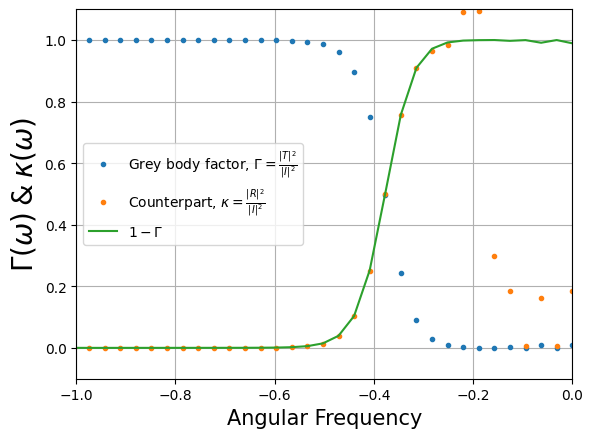

In [34]:
transmitted = time_series[0]
t_lower = np.argmin(np.abs(times - 440))
t_upper = np.argmin(np.abs(times - 650))
transmitted_windowed = transmitted[t_lower:t_upper]

incident = time_series[1]
i_lower = np.argmin(np.abs(times - 0))
i_upper = np.argmin(np.abs(times - 100))
incident_windowed = incident[i_lower:i_upper]

reflected = time_series[2]
r_lower = np.argmin(np.abs(times - 450))
r_upper = np.argmin(np.abs(times - 625))
reflected_windowed = reflected[r_lower:r_upper]

n = int(transmitted_windowed.shape[0])
q = int(incident_windowed.shape[0])
p = int(reflected_windowed.shape[0])

lengths = np.array([n, q, p])
N_fft = np.max(lengths)

transmitted_padded = np.zeros(N_fft, dtype = complex)
transmitted_padded[:n] = transmitted_windowed

incident_padded = np.zeros(N_fft, dtype = complex)
incident_padded[:q] = incident_windowed

reflected_padded = np.zeros(N_fft, dtype = complex)
reflected_padded[:p] = reflected_windowed

omega = 2*np.pi*fftfreq(N_fft, d=sim.dt)
omega = fftshift(omega)

transmitted_FT = fftshift(fft(transmitted_padded))*sim.dt/np.sqrt(2*np.pi)
transmitted_power = np.abs(transmitted_FT)**2

incident_FT = fftshift(fft(incident_padded))*sim.dt/np.sqrt(2*np.pi)
incident_power = np.abs(incident_FT)**2

reflected_FT = fftshift(fft(reflected_padded))*sim.dt/np.sqrt(2*np.pi)
reflected_power = np.abs(reflected_FT)**2


plt.figure()
plt.plot(omega, transmitted_power, label = r'Transmitted: $r_* = -300M$')
plt.plot(omega, incident_power, '.', label = r'Incident: $r_* = 150M$')
plt.plot(omega, reflected_power, label = r'Reflected: $r_* = 300M$')
plt.ylabel(r'$\left|F \left[\Psi \left( r_*, t\right)\right] \right|^2$', fontsize = 20)
plt.xlabel('Angular Frequency', fontsize = 20)
plt.xlim(-1.5, 0.5)
plt.legend()
plt.show()

plt.figure()
plt.plot(omega, reflected_power + transmitted_power, label = r'$|T|^2 + |R|^2$')
plt.plot(omega, incident_power, label = r'$|I|^2$')
plt.plot(omega, incident_power - (reflected_power + transmitted_power), label = r'$|I|^2 - (|T|^2 + |R|^2)$')
plt.ylabel(r'$\left|F \left[\Psi \left( r_*, t\right)\right] \right|^2$', fontsize = 20)
plt.xlabel('Angular Frequency', fontsize = 20)
plt.legend(loc = 'best')
plt.xlim(-1.5, 0.5)
plt.show()

print(incident_power - (reflected_power + transmitted_power))

# incident_power = transmitted_power + reflected_power
Gamma = transmitted_power/incident_power
Kappa = reflected_power/incident_power

plt.figure()
plt.plot(omega, Gamma, '.', label = r'Grey body factor, $\Gamma = \frac{|T|^2}{|I|^2}$')
plt.plot(omega, Kappa, '.', label = r'Counterpart, $\kappa = \frac{|R|^2}{|I|^2}$')
# plt.plot(omega, 16/225*omega**6, '.', label = r'Low frequency limit, $\Gamma ~ (\omega M)^6$')
plt.plot(omega, 1 - Gamma, label = r'$1 - \Gamma$') 
plt.xlabel('Angular Frequency', fontsize = 15)
plt.ylabel(r'$\Gamma (\omega) \: & \: \kappa (\omega)$', fontsize = 20)
plt.xlim(-1, 0)
plt.ylim(-0.1,1.1)
plt.grid()
plt.legend()
plt.show()

In [35]:
index = np.argmin(np.abs(Gamma - 0.5))
print(Gamma[index], omega[index])

#USING A HIGH FREQUENCY ~0.7 IMPROVES QUALITY OF GREY BODY FACTOR GRAPH
#BECAUSE YOU NEED TO CHANGE THE WINDOWING ON THE TIME SERIES TO ACCURATELY WINDOW

0.4979581738767803 -0.3770514466622411


In [36]:
m = 3
test = np.zeros(m + 1)

for i in range(4):
    test[i] += i

for i in range(1, m + 1):
    print(i)

1
2
3


In [41]:
def prony(t: np.array, signal: np.array, m: int):
    N = len(t)
    A = np.zeros((N - m, m), dtype = complex)
    b = signal[m:N]

    for j in range(m):
        A[:,j] = signal[m - j - 1:N - 1 - j]
    sol = np.linalg.lstsq(A, b)
    x = sol[0]

    coeffs = np.zeros(m + 1, dtype = complex)
    coeffs[-1] = 1.0

    for i in range(1, m + 1):
        coeffs[m - i] = -x[i - 1]
    
    z = poly.polyroots(coeffs)
    w_est = np.log(z)/(t[1] - t[0])
    return w_est

In [43]:
Prony_test = time_series[2]
qnms = prony(times, Prony_test, 20)
print(qnms)

[-2.82234202e+00+98.01125581j -2.80425664e+00-88.1389905j
 -2.80427653e+00+87.81196517j -2.74898754e+00-77.90204518j
 -2.74902926e+00+77.57503241j -2.65312006e+00-67.57868642j
 -2.65318798e+00+67.25169991j -2.50961265e+00-57.08901945j
 -2.50971596e+00+56.76208605j -2.30410650e+00-46.26710252j
 -2.30426804e+00+45.94029499j -2.00019072e+00-34.62460532j
 -2.00047607e+00+34.29834042j -2.76724763e-02 -0.29086046j
 -9.81953504e-04 +0.84750973j -2.07325549e-03 -0.75076066j
 -3.89165810e-03 -0.64001013j -3.14796721e-03 +0.66689j
 -5.36539512e-03 -0.43877044j -1.25986527e-03 -0.53988012j]
